#### Model Training and Evaluation Workflow

In this section, we will go through the entire process of training and evaluating a machine learning model for predicting NBA game outcomes. Below is an overview of the steps taken:

##### 1. **Removing Any Existing Model File**
Before training a new model, we ensure that any previously saved model file (`deepshot.pkl`) is deleted to prevent conflicts when saving the updated version.

##### 2. **Loading the Dataset**
We use `pandas` to load the dataset from a CSV file. A loading spinner is displayed using `rich` to provide visual feedback while the data is being read.

##### 3. **Preprocessing the Data**
- We drop unnecessary columns, such as `home_team` and `away_team`, since they are not used as input features for training.
- Any additional irrelevant statistical features (if specified) are also removed to optimize model performance.

##### 4. **Defining Features and Target Variable**
- The feature matrix `X` consists of all columns except the `winning_team` column.
- The target variable `y` is set as `winning_team`, which is already encoded as `0` (home win) and `1` (away win).

##### 5. **Splitting the Dataset**
The dataset is split into training and testing sets using an 80-20 ratio to evaluate model performance effectively.

##### 6. **Training the Model**
- A `XGBoostClassifier` is initialized with specific hyperparameters to improve model performance.
- A progress spinner is displayed while the model is being trained.

##### 7. **Evaluating the Model**
- Predictions are made on the test set.
- The model's accuracy is calculated and displayed using `rich` for better readability.
- A classification report is printed to show precision, recall, and F1-score for each class.

##### 8. **Saving the Model**
Finally, the trained model is saved as `deepshot.pkl` using `joblib` for future use.

This structured approach ensures that the model is trained, evaluated, and saved efficiently, with informative feedback at each step.



In [1]:
!pip install numpy pandas scikit-learn xgboost matplotlib seaborn beautifulsoup4 requests nicegui shap

In [2]:
# Importing libraries
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Removing the already existing model to overwrite it with the new one
try:
    os.remove("deepshot.pkl")
except:
    pass

# Start loading data
print("Loading Data...")

# Load CSV Data
df: pd.DataFrame = pd.read_csv("../data/csv/dataset.csv")
print("Data Loaded Successfully!")

# Drop columns that are not used for training (just home_team and away_team)
df: pd.DataFrame = df.drop(["date", "home_team", "away_team"], axis=1)

# Drop irrelevant stats columns
stats_to_drop: list[str] = []
for stat in stats_to_drop:
    df: pd.DataFrame = df.drop([f"home_{stat}", f"away_{stat}"], axis=1)

# Define features (X) and target (y)
X: pd.DataFrame = df.drop(
    "winning_team", axis=1
)  # Features (all columns except 'winning_team')
y: pd.Series = df["winning_team"]  # Target variable (already 0 or 1)

# Applying SMOTE for oversapling the minority feature (winning_team = 1)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Split the data into training and test sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42
)

# Train the XGBoost model
print("Training model... please wait.")

xgb: XGBClassifier = XGBClassifier(
    colsample_bytree=1.0,
    eval_metric="logloss",
    gamma=1.9053172502311604,
    learning_rate=0.016522533434963804,
    max_depth=13,
    min_child_weight=2,
    n_estimators=706,
    objective="binary:logistic",
    reg_alpha=2.2788875867642564,
    reg_lambda=8.617575532287624,
    subsample=0.6474449723608114,
    random_state=42,
)
xgb.fit(X_train, y_train)

print("Model training complete!")  # Update status once done

# Evaluate the model
print("Evaluating the model...")
y_pred: np.ndarray = xgb.predict(X_test)
accuracy: float = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(xgb, "deepshot.pkl")

Loading Data...
Data Loaded Successfully!
Splitting the dataset into training and testing sets...
Training model... please wait.
Model training complete!
Evaluating the model...

Model Accuracy: 70.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      3282
           1       0.72      0.68      0.70      3282

    accuracy                           0.71      6564
   macro avg       0.71      0.71      0.71      6564
weighted avg       0.71      0.71      0.71      6564



['deepshot.pkl']

#### Loading and Analyzing the Model  

In this section, we load a pre-trained Random Forest model (`deepshot.pkl`) using `joblib`.  
We then configure Pandas display options to ensure that all columns and rows are fully visible in the output.  

Once the model is loaded, we extract and analyze feature importances to understand which factors contribute most to the predictions.  
The feature importance values are obtained from the model and combined with feature names into a Pandas DataFrame.  

Finally, we sort the features in descending order of importance and display the results using `console.print` for better readability.  
Afterward, we reset Pandas display options to their default values to avoid affecting subsequent outputs.

In [3]:
# Importing libraries
import joblib
import pandas
from xgboost import XGBClassifier
import numpy as np

# Loading the model
xgb: XGBClassifier = joblib.load("deepshot.pkl")

# Load CSV Data
df: pandas.DataFrame = pandas.read_csv("../data/csv/dataset.csv")

# Drop columns that are not used for training (just home_team and away_team)
df: pandas.DataFrame = df.drop(["date", "home_team", "away_team"], axis=1)

# Drop irrelevant stats columns
stats_to_drop: list[str] = []
for stat in stats_to_drop:
    df: pandas.DataFrame = df.drop([f"home_{stat}", f"away_{stat}"], axis=1)

# Define features (X) and target (y)
X: pandas.DataFrame = df.drop(
    "winning_team", axis=1
)  # Features (all columns except 'winning_team')
y: pandas.Series = df["winning_team"]  # Target variable (already 0 or 1)

# Set options to display all columns
pandas.set_option("display.max_columns", None)  # No column truncation
pandas.set_option("display.width", None)  # Automatically adjust width
pandas.set_option("display.max_rows", None)  # Show all rows, if necessary

# Now print the feature importance DataFrame
print("\nFeature Importances:")
feature_importances: np.ndarray = xgb.feature_importances_
features: pandas.core.indexes.base.Index = X.columns  # Get the feature names

# Create a DataFrame to visualize feature importance
importance_df: pandas.DataFrame = pandas.DataFrame({"Feature": features, "Importance": feature_importances})

# Sort by importance in descending order
importance_df: pandas.DataFrame = importance_df.sort_values(by="Importance", ascending=False)

# Print the DataFrame with feature importances
print(importance_df)

# Reset Pandas display options to default (optional)
pandas.reset_option("display.max_columns")
pandas.reset_option("display.width")
pandas.reset_option("display.max_rows")


Feature Importances:
           Feature  Importance
35       home_nrtg    0.055126
73       away_nrtg    0.043182
3      home_fg_pct    0.035839
75  away_ast_ratio    0.028327
37  home_ast_ratio    0.027242
41     away_fg_pct    0.024332
44    away_fg3_pct    0.021262
69    away_efg_pct    0.018354
64         away_ts    0.017239
26         home_ts    0.016641
6     home_fg3_pct    0.015311
12     home_ft_pct    0.014656
9     home_fg2_pct    0.014652
34    home_ft_rate    0.014532
50     away_ft_pct    0.014254
31    home_efg_pct    0.013091
47    away_fg2_pct    0.012148
72    away_ft_rate    0.011791
25      home_3ptar    0.011410
46       away_fg2a    0.011312
24        home_ftr    0.011182
57        away_tov    0.011000
62        away_ftr    0.010803
63      away_3ptar    0.010746
21       home_ortg    0.010734
36    home_ast_tov    0.010648
18        home_blk    0.010646
70    away_tov_pct    0.010645
59       away_ortg    0.010644
56        away_blk    0.010616
19        home_to

#### Model Loading and Feature Importance Analysis

In this section, we load a pre-trained machine learning model and prepare the dataset for evaluation. The steps are as follows:

1. **Load the Model:** We use `joblib` to load a previously trained model (`deepshot.pkl`).
2. **Load and Preprocess Data:** The dataset is read from a CSV file. Since some columns like `home_team` and `away_team` are not used for training, we drop them.
3. **Define Features and Target Variable:**
   - `X`: Contains all feature columns except the target variable (`winning_team`).
   - `y`: The target variable, which indicates whether the home team won (0) or the away team won (1).
4. **Split Data for Testing:** We split the dataset into training and testing sets using an 80/20 ratio.
5. **Feature Importance Analysis with SHAP:**
   - A sample of 250 test instances is selected.
   - SHAP (SHapley Additive exPlanations) values are computed using a TreeExplainer.
   - The feature importance is visualized using a SHAP summary plot to understand how different features influence the model’s predictions.

This analysis helps us interpret the model’s decision-making process and identify the most influential factors in predicting game outcomes.

100%|===================| 999/1000 [02:47<00:00]        

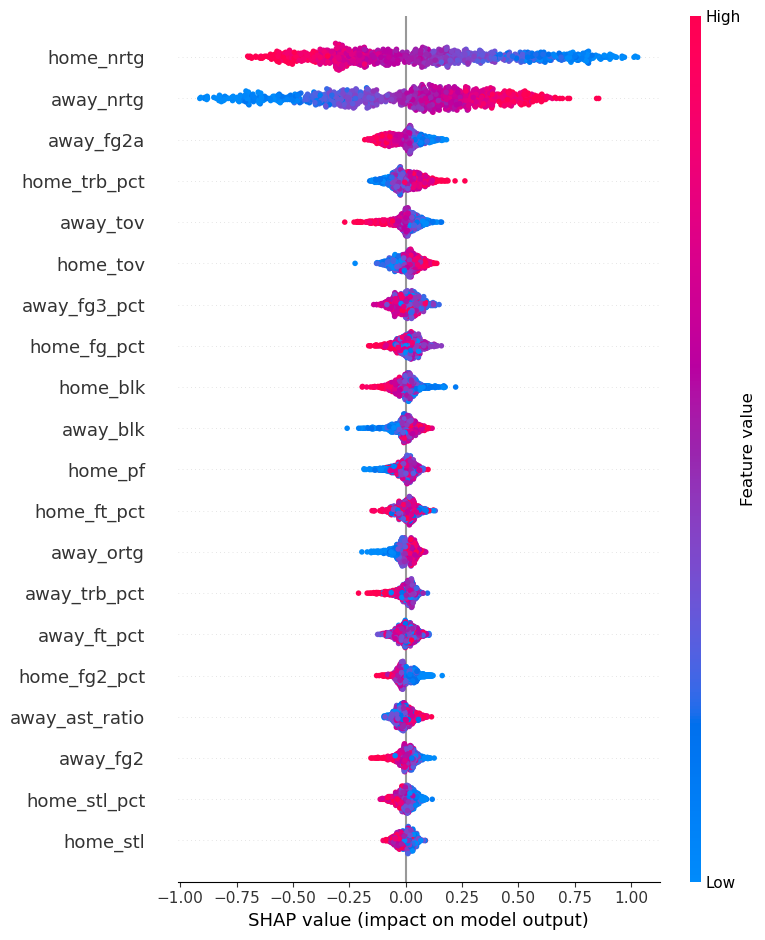

In [4]:
# Importing libraries
import joblib
from xgboost import XGBClassifier
import pandas
from sklearn.model_selection import train_test_split
import shap


# Loading the model
xgb: XGBClassifier = joblib.load("deepshot.pkl")

# Load CSV Data
df: pandas.DataFrame = pandas.read_csv("../data/csv/dataset.csv")

# Drop columns that are not used for training (just home_team and away_team)
df: pandas.DataFrame = df.drop(["date", "home_team", "away_team"], axis=1)

# Define features (X) and target (y)
X: pandas.DataFrame = df.drop(
    "winning_team", axis=1
)  # Features (all columns except 'winning_team')
y: pandas.Series = df["winning_team"]  # Target variable (already 0 or 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Analyzing feature importance with SHAP values and chart
sample: pandas.core.frame.DataFrame = X_test.sample(1000, random_state=42)
explainer: shap.explainers._tree.TreeExplainer = shap.TreeExplainer(xgb, sample)
shap_values: shap._explanation.Explanation = explainer(sample)
shap.summary_plot(shap_values, sample)

In [5]:
import os
print(os.path.exists('deepshot.pkl'))

True
